Mean Squared Error: 27.385070522937664
Mean absolute error: 1.1152018207738563
Root Mean squared error: 5.233074672020042
R-squared Score: -1.5493363906135897


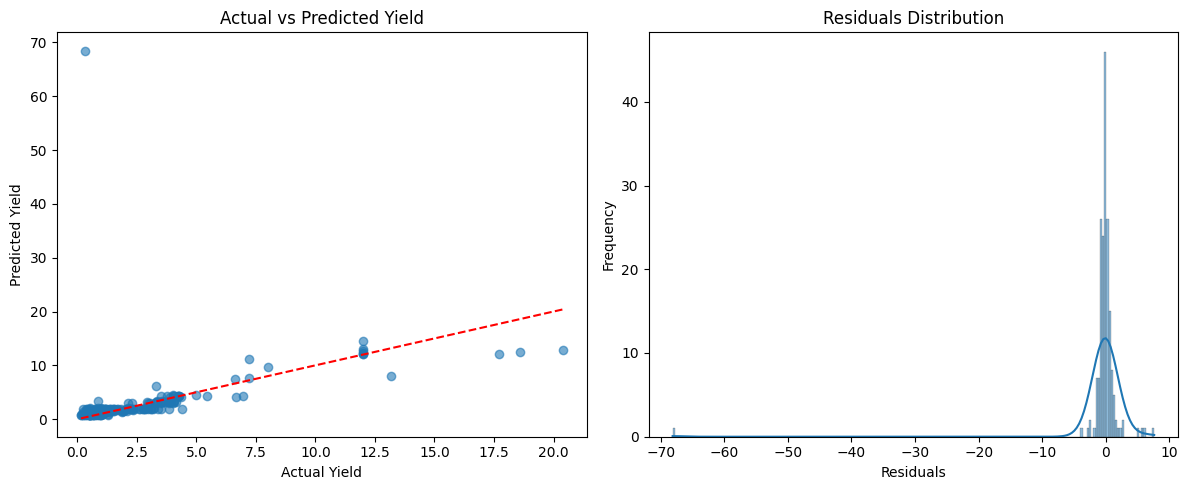

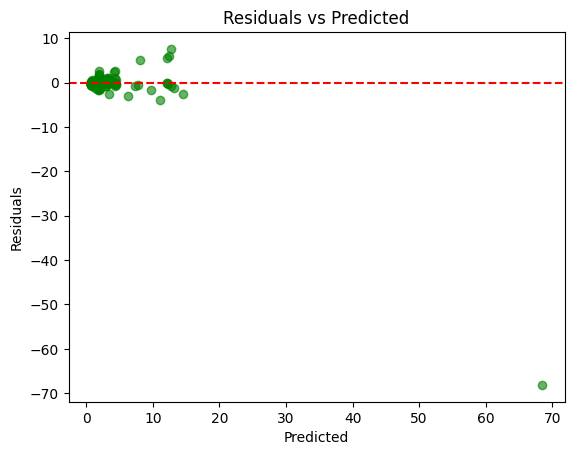

/tmp/ipykernel_5947/2896365361.py:192: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color='orange')


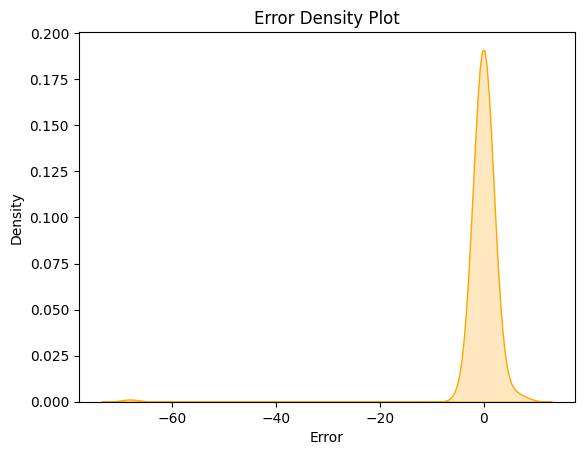

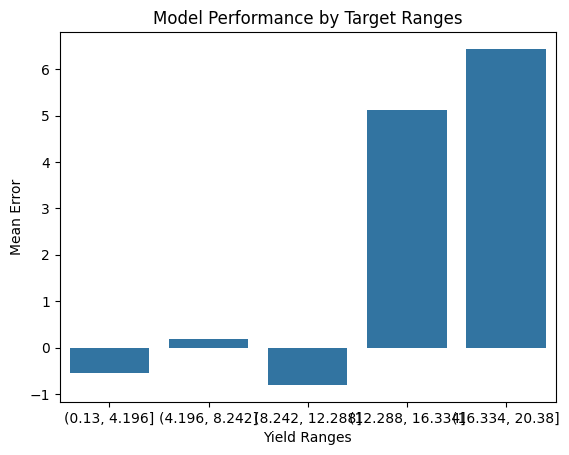

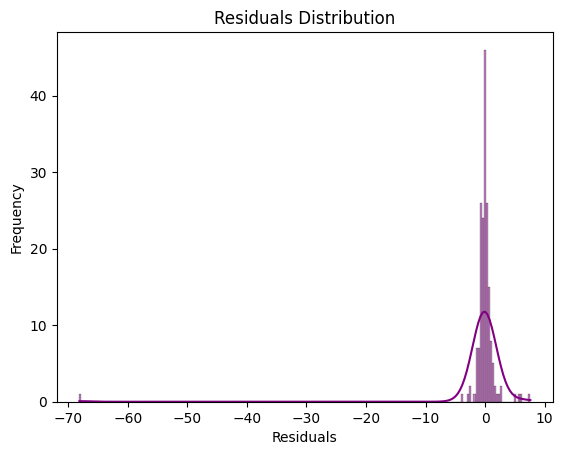

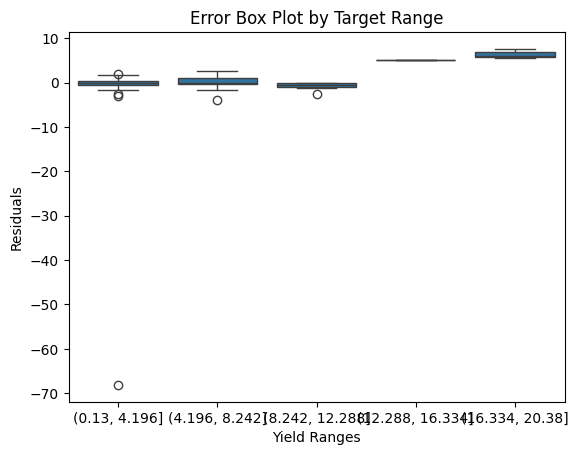

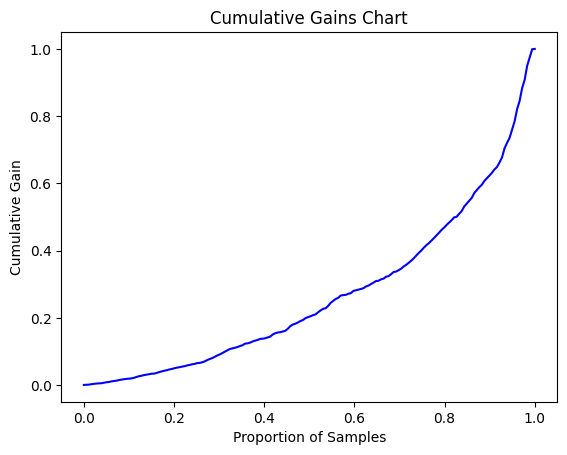

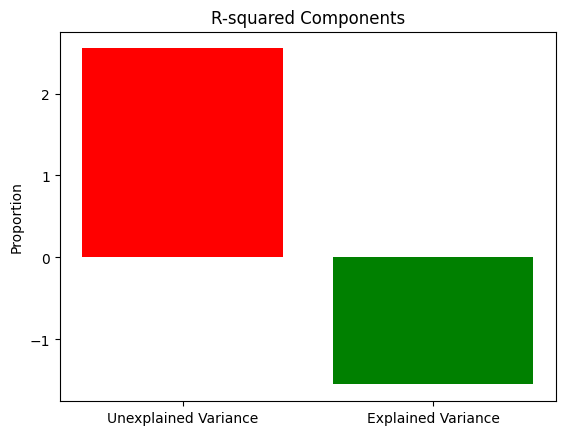

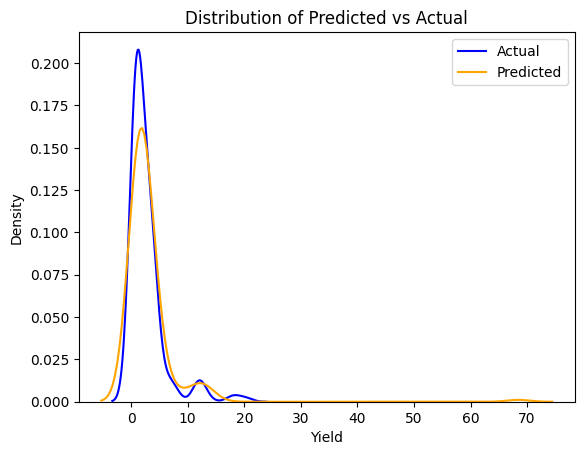

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle



class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        # Stopping conditions
        if n_samples < self.min_samples_split or (self.max_depth is not None and depth >= self.max_depth):
            return np.mean(y)

        best_split = None
        best_mse = float('inf')
        
        # Find best split
        for feature_idx in range(n_features):
            unique_values = np.unique(X[:, feature_idx])
            
            for threshold in unique_values:
                # Split data
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                # Skip if split is trivial
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue
                
                # Calculate weighted MSE
                left_mse = np.mean((y[left_mask] - np.mean(y[left_mask]))**2)
                right_mse = np.mean((y[right_mask] - np.mean(y[right_mask]))**2)
                weighted_mse = (len(y[left_mask]) * left_mse + len(y[right_mask]) * right_mse) / n_samples
                
                # Update best split
                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_split = {
                        'feature': feature_idx,
                        'threshold': threshold,
                        'left_mask': left_mask,
                        'right_mask': right_mask
                    }
        
        # If no good split found, return mean
        if best_split is None:
            return np.mean(y)
        
        # Recursive splitting
        left_subtree = self._build_tree(X[best_split['left_mask']], y[best_split['left_mask']], depth + 1)
        right_subtree = self._build_tree(X[best_split['right_mask']], y[best_split['right_mask']], depth + 1)
        
        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        
        feature = tree['feature']
        if x[feature] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

class BaggingRegressor:
    def __init__(self, base_model, n_estimators=10, max_depth=None):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        # Reset models before training
        self.models = []
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # Create and train model
            model = self.base_model(max_depth=self.max_depth)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        # Aggregate predictions from all models
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=1)




def main():
    # Load data
    data = pd.read_csv('data.csv')

    # Separate features and target
    y = data['Yield(Tonne/Hectare)'].values
    X = data.drop(['Yield(Tonne/Hectare)'], axis=1)

    # One-hot encoding for categorical features
    X = pd.get_dummies(X, drop_first=True)
    X_values = X.values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_values, y, test_size=0.2, random_state=42)

    # Create and train Bagging Regressor
    bagging_model = BaggingRegressor(
        base_model=DecisionTreeRegressor, 
        n_estimators=100, 
        max_depth=5
    )
    bagging_model.fit(X_train, y_train)
    
    ## Dumping the model
    with open("sri_bagging_model_v2.pkl", "wb") as file:
        pickle.dump(bagging_model, file)

    # Predictions
    y_pred = bagging_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean absolute error: {mae}")
    print(f"Root Mean squared error: {rmse}")
    print(f"R-squared Score: {r2}")

    # Visualization
    plt.figure(figsize=(12, 5))
    
    # Actual vs Predicted Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Yield')
    plt.ylabel('Predicted Yield')
    plt.title('Actual vs Predicted Yield')
    plt.savefig("Results/act_vs_pred.jpg")
    
    # Residuals Plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.savefig("Results/act_vs_pred.jpg")
    
    plt.tight_layout()
    plt.show() 

    # Residual vs Predicted plot
    plt.scatter(y_pred, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')

    plt.savefig("Results/act_vs_pred.jpg")
    plt.show() 


    ## Error density plot

    sns.kdeplot(residuals, shade=True, color='orange')
    plt.title('Error Density Plot')
    plt.xlabel('Error')
    plt.ylabel('Density')

    plt.savefig("Results/error_density.jpg")
    plt.show()


    ## Model Performance across different ages
    ranges = pd.cut(y_test, bins=5)
    range_means = [np.mean(y_test[ranges == r] - y_pred[ranges == r]) for r in ranges.categories]
    sns.barplot(x=ranges.categories, y=range_means)
    plt.title('Model Performance by Target Ranges')
    plt.xlabel('Yield Ranges')
    plt.ylabel('Mean Error')

    plt.savefig("Results/model_performance.jpg")
    plt.show() 

    ## residual distribution plot

    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, color='purple')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')

    plt.savefig("Results/residual.jpg")
    plt.show()


    ## Box plot of errors by target ranges

    df = pd.DataFrame({'Actual': y_test, 'Residuals': residuals})
    df['Range'] = pd.cut(df['Actual'], bins=5)
    sns.boxplot(x='Range', y='Residuals', data=df)
    plt.title('Error Box Plot by Target Range')
    plt.xlabel('Yield Ranges')
    plt.ylabel('Residuals')

    plt.savefig("Results/Target_ranges.jpg")
    plt.show()

    ## Cummulative gain chart

    sorted_indices = np.argsort(y_pred)
    cumulative_gains = np.cumsum(y_test[sorted_indices]) / np.sum(y_test)
    plt.plot(np.linspace(0, 1, len(y_test)), cumulative_gains, color='blue')
    plt.title('Cumulative Gains Chart')
    plt.xlabel('Proportion of Samples')
    plt.ylabel('Cumulative Gain')

    plt.savefig("Results/CGain.jpg")
    plt.show() 

    ### R^2 visualization

    r2 = r2_score(y_test, y_pred)
    plt.bar(['Unexplained Variance', 'Explained Variance'], [1 - r2, r2], color=['red', 'green'])
    plt.title('R-squared Components')
    plt.ylabel('Proportion')

    plt.savefig("Results/r2_visalize.jpg")
    plt.show() 


    ## Predicted values distribution 

    sns.kdeplot(y_test, label='Actual', color='blue')
    sns.kdeplot(y_pred, label='Predicted', color='orange')
    plt.title('Distribution of Predicted vs Actual')
    plt.xlabel('Yield')
    plt.ylabel('Density')
    plt.legend()

    plt.savefig("Results/pred_val_distri.jpg")
    plt.show()










if __name__ == "__main__":
    main()

### Result graphs